https://keras.io/examples/nlp/pretrained_word_embeddings/

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec,KeyedVectors

import logging
import nltk
from nltk.corpus import brown   
import os 

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download('brown')

import csv
import transformers
from scipy.spatial.distance import cosine
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#% matplotlib inline

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
"""sentences = brown.sents()

def IsWordInBrownData(word):
	print(word)
	return [word] in brown.sents()

def CheckFourWordsInBrownData(words):
	for w in words:
		if IsWordInBrownData(w):
			print(w)
			return False
	return True

def GetPairs():
	word_pairs = []
	with open('DataFiles/PhraseData.csv', 'r') as file:
		for row in file:
			if 'Phrase1' in row.strip():continue #Skip heading
			words = row.split(" ")
			if CheckFourWordsInBrownData([words[0], words[2], words[1][:-1], words[3][:-1]]):
				word_pairs.append([words[0], words[2]])
				word_pairs.append([words[1][:-1], words[3][:-1]])
	return word_pairs
GetPairs()"""

'sentences = brown.sents()\n\ndef IsWordInBrownData(word):\n\tprint(word)\n\treturn [word] in brown.sents()\n\ndef CheckFourWordsInBrownData(words):\n\tfor w in words:\n\t\tif IsWordInBrownData(w):\n\t\t\tprint(w)\n\t\t\treturn False\n\treturn True\n\ndef GetPairs():\n\tword_pairs = []\n\twith open(\'DataFiles/PhraseData.csv\', \'r\') as file:\n\t\tfor row in file:\n\t\t\tif \'Phrase1\' in row.strip():continue #Skip heading\n\t\t\twords = row.split(" ")\n\t\t\tif CheckFourWordsInBrownData([words[0], words[2], words[1][:-1], words[3][:-1]]):\n\t\t\t\tword_pairs.append([words[0], words[2]])\n\t\t\t\tword_pairs.append([words[1][:-1], words[3][:-1]])\n\treturn word_pairs\nGetPairs()'

# Data Generate

In [74]:
def SearchBrownForWord(search_word):	
	for sent in brown.sents():
		if search_word in sent:
			return True
		else:
			continue
	return False

# read the words from your WordData.csv file
def GetWords():
    words = []
    with open('DataFiles/WordData.csv', 'r') as f:       
        for line in f:
            if line.strip()=='Word':continue #Skip heading
			#Missing Words from Corupus
            if SearchBrownForWord(line.strip()):
                words.append(line.strip())
    return words

def GetWordPairs():
	words = []
	with open('DataFiles/PhraseData.csv', 'r') as f:  
		pair1, pair2 = [], []
		for line in f:
			if line.strip()=='Word':continue #Skip heading
			for phrase in f:
				phrase = phrase.split(" ")
				#print(phrase)
				#Missing Words from Corupus
				if SearchBrownForWord(phrase[0]) and SearchBrownForWord(phrase[1][:-1]) and SearchBrownForWord(phrase[2]) and SearchBrownForWord(phrase[3][:-1]):
					words.append([phrase[0], phrase[2]])
					words.append([phrase[1][:-1], phrase[3][:-1]])
				else:
					continue
	#print(words)
	return words

word_pairs = GetWordPairs()
word_list = GetWords()

print("First 5 Word Pairs: ")
print(word_pairs[:5])

print("\nFirst 5 Words: ")
word_list[:5]

First 5 Word Pairs: 
[['party', 'government'], ['official', 'leader'], ['state', 'government'], ['control', 'intervention'], ['tax', 'interest'], ['charge', 'rate'], ['party', 'opposition'], ['leader', 'member'], ['tax', 'family'], ['credit', 'allowance'], ['state', 'county'], ['benefit', 'council'], ['state', 'town'], ['control', 'council'], ['state', 'county'], ['benefit', 'council'], ['government', 'party'], ['intervention', 'leader'], ['market', 'board'], ['leader', 'member'], ['labour', 'housing'], ['cost', 'benefit'], ['management', 'computer'], ['structure', 'system'], ['family', 'tax'], ['allowance', 'rate'], ['tax', 'wage'], ['credit', 'increase'], ['management', 'planning'], ['skill', 'committee'], ['education', 'service'], ['authority', 'department'], ['assistant', 'company'], ['manager', 'director'], ['kitchen', 'bedroom'], ['door', 'window'], ['intelligence', 'bus'], ['service', 'company'], ['tax', 'datum'], ['charge', 'system'], ['world', 'management'], ['economy', 'struc

['development', 'plan', 'action', 'training', 'education']

# Word2Vec

In [75]:
class W2VModel():
	def __init__(self, vector_dims, dir='C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_', printing=False):
		self.vector_dims = vector_dims
		if not os.path.exists(dir+str(vector_dims)):
			self.model = gensim.models.Word2Vec(brown.sents(), min_count=1,vector_size=vector_dims, window=5, workers=4)
			self.model.save(dir+str(vector_dims))
			if printing:print("Made Word2Vec Model of ", str(vector_dims), " dimensions")
		else:
			self.model = Word2Vec.load(dir+str(vector_dims))
			if printing:print("Load Word2Vec Model of ", str(vector_dims), " dimensions")
		
	
	def getvector(self, words):
		return self.model.wv[words]

dimensions = [10,20,30,40,50,60,70,80,90] + list(np.arange(100,800,100))

for vector_dims in dimensions: W2VModel(vector_dims, printing=True)

W2V = W2VModel(768)
print("First 10 dims of second word in 768 dims: ")
W2V.getvector(word_list[1])[:10]

Load Word2Vec Model of  10  dimensions
Load Word2Vec Model of  20  dimensions
Load Word2Vec Model of  30  dimensions
Load Word2Vec Model of  40  dimensions
Load Word2Vec Model of  50  dimensions
Load Word2Vec Model of  60  dimensions
Load Word2Vec Model of  70  dimensions
Load Word2Vec Model of  80  dimensions
Load Word2Vec Model of  90  dimensions
Load Word2Vec Model of  100  dimensions
Load Word2Vec Model of  200  dimensions
Load Word2Vec Model of  300  dimensions
Load Word2Vec Model of  400  dimensions
Load Word2Vec Model of  500  dimensions
Load Word2Vec Model of  600  dimensions
Load Word2Vec Model of  700  dimensions
First 10 dims of second word in 768 dims: 


array([-0.111239  , -0.11238351, -0.02475715,  0.07736997,  0.05225196,
       -0.10167263, -0.11997304, -0.03647869, -0.14775316,  0.01629074],
      dtype=float32)

## Testing

In [76]:
model_100 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(100))
model_600 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(600))
model_700 = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(700))
cosine(model_100.wv[word_list[1]],model_100.wv[word_list[2]]), cosine(model_600.wv[word_list[1]],model_600.wv[word_list[2]]), cosine(model_700.wv[word_list[1]],model_700.wv[word_list[2]])

(0.09658396244049072, 0.07899695634841919, 0.07852572202682495)

In [78]:
dot_prds = []
for dims in dimensions:
	model = Word2Vec.load('C:\\Users\\henry\\Desktop\\MastersProject\\QNLP_MasterWork\\Word2VecModels\\brown_model_'+str(dims))
	dim_dot_prod = []
	for pair in word_pairs:
		#print(pair)
		dim_dot_prod.append(cosine(model.wv[pair[0]],model.wv[pair[1]]))
		dim_dot_prod.append(0)
	dot_prds.append(dim_dot_prod)
dot_prods = np.array(dot_prds)
dot_prods.shape

(16, 124)

C:\Users\henry\AppData\Local\Temp\ipykernel_16076\884194603.py:7: RuntimeWarning: invalid value encountered in double_scalars
  scaled_line.append(100*abs((word_dotprod[0] - val)/word_dotprod[i-1]))


Text(0, 0.5, 'Percentage Change from current dimension to 700')

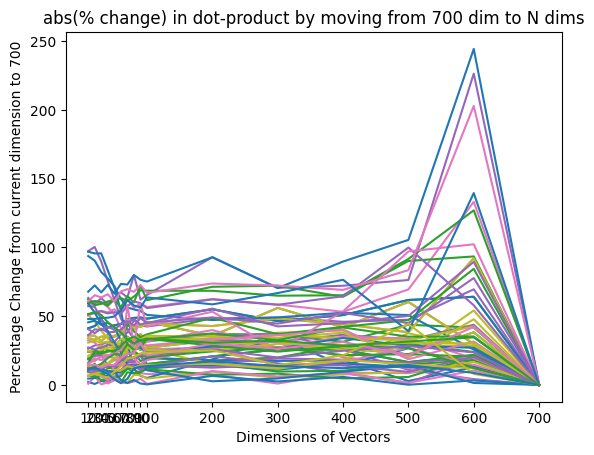

In [79]:
for word_dotprod in dot_prods.T:
	scaled_line = []
	for i, val in reversed(list(enumerate(word_dotprod))):
		if i == 0:
			scaled_line.append(val - val)
		else:
			scaled_line.append(100*abs((word_dotprod[0] - val)/word_dotprod[i-1]))

	plt.plot(dimensions, scaled_line)
plt.title("abs(% change) in dot-product by moving from 700 dim to N dims")
plt.xticks(dimensions)
plt.xlabel("Dimensions of Vectors")
plt.ylabel("Percentage Change from current dimension to 700")

# BERT

In [86]:
class BertEncodingWords():
	#https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=Zn0n2S-FWZih
	
	def __init__(self, data):
		# Load pre-trained model tokenizer (vocabulary)
		self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
		self.words = data
		self.model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True).eval()# output_hidden_states is whether the model returns all hidden-states. # Put the model in "evaluation" mode, meaning feed-forward operation. 
		pass
	
	def getWordEmbedding(self, word):
		marked_text = "[CLS] " + word + " [SEP]"
		tokenized_text = self.tokenizer.tokenize(marked_text)	# Tokenize our sentence with the BERT tokenizer.
		return(tokenized_text)	# Print out the tokens.
	
	def preprocessSentence(self, word):
		# Add the special tokens.
		tokenized_text = self.getWordEmbedding(word)
		# Map the token strings to their vocabulary indeces.
		indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)

		# Mark each of the 22 tokens as belonging to sentence "1".
		segments_ids = [1] * len(tokenized_text)

		# Convert inputs to PyTorch tensors
		tokens_tensor = torch.tensor([indexed_tokens])
		segments_tensors = torch.tensor([segments_ids])
		return tokens_tensor, segments_tensors
	
	def hiddenLayersBERT(self, word):
		hidden_states = [] 
		with torch.no_grad():
			outputs = self.model(word[0])
			# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
			hidden_states.append(outputs[2])
		return hidden_states

	def GetEmbeddingsForWord(self, hidden):
		# Stores the token vectors, with shape [22 x 768]
		token_vecs_sum = []

		# `token_embeddings` is a [22 x 12 x 768] tensor.

		# For each token in the sentence...
		for token in hidden:
			# `token` is a [12 x 768] tensor
			# Sum the vectors from the last four layers.
			sum_vec = torch.sum(token[0][0], dim=0)
			
			# Use `sum_vec` to represent `token`.
			token_vecs_sum.append(sum_vec)
		token_embedding_list = token_vecs_sum
		return token_embedding_list
	
	def GetTokenVecSum(self, hidden_state):
		# Stores the token vectors, with shape [22 x 768]
		token_vecs_cum_sum = []

		# `token_embeddings` is a [22 x 12 x 768] tensor.

		# For each token in the sentence...
		for token in hidden_state:

			# `token` is a [12 x 768] tensor
			# Sum the vectors from the last four layers.
			sum_vec = torch.sum(token[0][0], dim=0)
			
			# Use `sum_vec` to represent `token`.
			token_vecs_cum_sum.append(sum_vec)
		token_vecs_sum = token_vecs_cum_sum
		return token_vecs_sum

	def getWordVector(self, word):
		word_to_evaluate = self.preprocessSentence(word)
		hidden = self.hiddenLayersBERT(word_to_evaluate)
		embeddings = self.GetEmbeddingsForWord(hidden)
		return np.array(embeddings[0])

	
	def evaluateWordPair(self, row_numbers):
		sents_to_evaluate = [self.preprocessSentence(self.words[row_numbers[0]]), self.preprocessSentence(self.words[row_numbers[1]])]
		hidden = self.hiddenLayersBERT(sents_to_evaluate)
		embeddings = self.GetEmbeddingsForBothWords(hidden)
		return cosine(embeddings[1][0], embeddings[1][1])

	def evaluateAllSentPairs(self, word_list):
			res = []
			for idx, word in enumerate(word_list):
				if idx % 2 == 0:
					try:
						res.append(1 - cosine(self.getWordVector(word), self.getWordVector(word_list[idx+1])))
					except:
						continue
				else:
					continue
			return res
	
	def GetAllBERTVectors(self, word_list):
		res = []
		for idx, word in enumerate(word_list):
			res.append(self.getWordVector(word))
		return res

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Cosine Similarity')

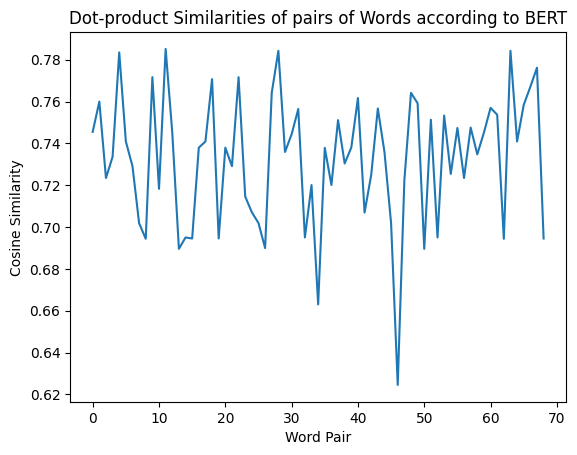

In [87]:
bertWwords = BertEncodingWords(word_list)

similarities = bertWwords.evaluateAllSentPairs(word_list)
plt.plot(similarities)
plt.title("Dot-product Similarities of pairs of Words according to BERT")
plt.xlabel("Word Pair")
plt.ylabel("Cosine Similarity")

# Rotations

In [89]:
def RotateWordVector(input_word_vector):
	rotated_word_vector = []
	for comaprison_word in word_list:
		rotated_word_vector.append(1-cosine(input_word_vector, W2V.getvector(comaprison_word)))
	return rotated_word_vector

W2V = W2VModel(768)
rotated_words = dict()
for word in word_list:
	rotated_word_vector = []
	rotated_word_vector = RotateWordVector(W2V.getvector(word))
	normalized_rotated_vector = np.array(rotated_word_vector)
	scaled_normalized_rotated_vector = np.interp(normalized_rotated_vector, (normalized_rotated_vector.min(), normalized_rotated_vector.max()), (-1, +1))
	rotated_words.update({str(word): scaled_normalized_rotated_vector})

In [90]:
word = 'board'
comaprison_word = 'market'
1-cosine(W2V.getvector(word), W2V.getvector(comaprison_word)), 1-cosine(rotated_words[word], rotated_words[comaprison_word]), len(rotated_words['board']),len(rotated_words['market']) 

(0.9227846264839172, 0.9468292057114999, 138, 138)

In [91]:
def evaluateSimilaritiesOfMethods():
	res = dict()
	word_pairs = GetWordPairs()
	for idx, word in enumerate(word_pairs):
		res.update({str(word[0] + " "+ word[1]):1 - cosine(rotated_words[word[0]], rotated_words[word[1]])})
	return res

rotated_similatities = evaluateSimilaritiesOfMethods()
#rotated_similatities

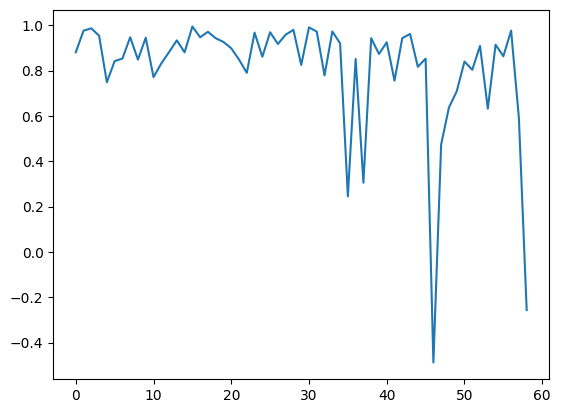

In [92]:
plt.plot(rotated_similatities.values())

# Single Value Decomposition

https://en.wikipedia.org/wiki/Singular_value_decomposition#:~:text=equivalent%20to%20zero.-,Low%2Drank%20matrix%20approximation,-%5Bedit%5D

In [93]:
def PerformSVD(A, N):
    # Perform SVD on the input vector
    U, D, Vt = np.linalg.svd(A)
    print(U.shape, D.shape, Vt.shape)
    # Select the first N columns of the U matrix
    U_reduced = U[:, :N]
    # Multiply the reduced U matrix with the S matrix
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

PerformSVD(np.array([[2,3, 9, 9, 9, 34,5, 4,5,6,44,5,6,4,3,9]]),1)

(1, 1) (1,) (16, 16)


array([[-60.14149982]])

In [94]:
from sklearn.decomposition import PCA

def DimReduceByPCA(input_array, new_dims):
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

In [95]:
bertWwords = BertEncodingWords(GetWords())
bertVectors = np.array(bertWwords.GetAllBERTVectors(word_list))
bertVectors.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(138, 768)

In [96]:
reduced_BERT_vec = DimReduceByPCA(bertVectors, 9)
cosine(reduced_BERT_vec[0], reduced_BERT_vec[1]), cosine(bertVectors[0], bertVectors[1])

(0.6284794807434082, 0.2544633746147156)

# Autoencoder (Symetric & Deep)

In [ ]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
encoding_dim = 15 
input_img = Input(shape=(768,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoded representation of code 
decoded1 = Dense(768, activation='sigmoid')(encoded)
decoded2 = Dense(384, activation='sigmoid')(encoded)
decoded3 = Dense(96, activation='sigmoid')(encoded)
decoded4 = Dense(20, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_img, [decoded1, decoded2, decoded3, decoded4])

# This model shows encoded images
encoder = Model(input_img, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
x_train = bertVectors
x_train.shape

(143, 768)

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(143, 768)


In [ ]:
x_test.shape[1:]

(784,)

# Evaluation: Similarities in Methods

In [103]:
BERT = BertEncodingWords(word_list)
W2V = W2VModel(768)

BERT_dots = dict()
W2V_dots = dict()
ROTATED_dots = dict()
for pair in word_pairs:
	print(pair)
	#Try accept as some words do not work in the W2V eg:W2V.wv['plan'] -> Error
	W2V_dots.update({pair[0]+" "+pair[1]:1 - cosine(W2V.getvector(pair[0]), W2V.getvector(pair[1]))})
	ROTATED_dots.update({pair[0]+" "+pair[1]:1 - cosine(rotated_words[pair[0]], rotated_words[pair[1]])})
	BERT_dots.update({pair[0]+" "+pair[1]:1 - cosine(BERT.getWordVector(pair[0]), BERT.getWordVector(pair[1]))})
	#print(pair[0], pair[1], len(BERT_dots), len(W2V_dots), np.round(W2V_dots[pair[0]+" "+pair[1]], 2), np.round(BERT_dots[pair[0]+" "+pair[1]], 2))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['party', 'government']
['official', 'leader']
['state', 'government']
['control', 'intervention']
['tax', 'interest']
['charge', 'rate']
['party', 'opposition']
['leader', 'member']
['tax', 'family']
['credit', 'allowance']
['state', 'county']
['benefit', 'council']
['state', 'town']
['control', 'council']
['state', 'county']
['benefit', 'council']
['government', 'party']
['intervention', 'leader']
['market', 'board']
['leader', 'member']
['labour', 'housing']
['cost', 'benefit']
['management', 'computer']
['structure', 'system']
['family', 'tax']
['allowance', 'rate']
['tax', 'wage']
['credit', 'increase']
['management', 'planning']
['skill', 'committee']
['education', 'service']
['authority', 'department']
['assistant', 'company']
['manager', 'director']
['kitchen', 'bedroom']
['door', 'window']
['intelligence', 'bus']
['service', 'company']
['tax', 'datum']
['charge', 'system']
['world', 'management']
['economy', 'structure']
['company', 'tax']
['director', 'credit']
['league', 'fa

In [104]:
BERT_dots

{'party government': 0.7750695943832397,
 'official leader': 0.7522398829460144,
 'state government': 0.8133704662322998,
 'control intervention': 0.7376946806907654,
 'tax interest': 0.6943225264549255,
 'charge rate': 0.717332661151886,
 'party opposition': 0.7518858313560486,
 'leader member': 0.8111140727996826,
 'tax family': 0.7233424186706543,
 'credit allowance': 0.691547691822052,
 'state county': 0.8042483925819397,
 'benefit council': 0.6971415281295776,
 'state town': 0.7847762107849121,
 'control council': 0.7227463722229004,
 'government party': 0.7750695943832397,
 'intervention leader': 0.735630452632904,
 'market board': 0.6992111802101135,
 'labour housing': 0.722057580947876,
 'cost benefit': 0.7255298495292664,
 'management computer': 0.7612450122833252,
 'structure system': 0.8126272559165955,
 'family tax': 0.7233424186706543,
 'allowance rate': 0.7304175496101379,
 'tax wage': 0.7193946838378906,
 'credit increase': 0.7105820178985596,
 'management planning': 0.7

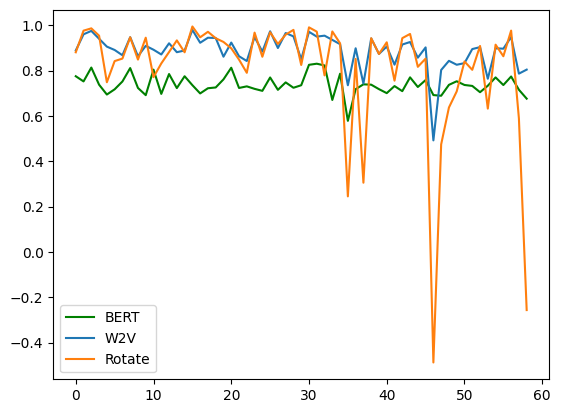

In [106]:
fig, ax = plt.subplots()

plt.plot(BERT_dots.values(), color='g', label = 'BERT')
plt.plot(W2V_dots.values(), label = 'W2V')
plt.plot(ROTATED_dots.values(), label = 'Rotate')
plt.legend()
plt.show()